<a href="https://colab.research.google.com/github/miaanastasia/lstm_pipeline/blob/main/LSTM_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM-Based Stock Price Prediction**

This notebook demonstrates a stock prediction pipeline using machine learning and LSTM neural networks, with technical and market-based features, visual evaluation, and an interactive UI for exploring results.

> *This program is optimized for Google Colab Pro accounts with GPU access and at least ten available computing units.*

## User Guide

#### Processor
1. Click `Connect` at the top right of the notebook.
2. Select `L4 GPU` or `T4 GPU` from the runtime options.
3. Verify connectivity with green check mark.

#### Pipeline
1. In the Colab menu bar, go to **Runtime > Run All.**
2. The default ticker is set to `DOW`.
3. Wait a few moments while all cells execute.
4. Once complete, check the task bar at the bottom for confirmation.


> ***Tips:***
> - Collapse sections using the bold headers for cleaner navigation.
> - To run a specific section, hover over the `[ ]` icon below the collapsed header and click the play button.

#### User Interface
1. Scroll to the **User Interface** section at the bottom of the notebook.
2. The dashboard appears by default under the `Pipeline` tab.
3. Select a ticker from the dropdown and click 'Run Pipeline'.
4. Watch the model train and view output loss and average percentage error.
5. Navigate to the `Visualization` tab explore various charts and performance metrics.
6.Select a visualization and click 'Show' (some may take a few moments to load).
7. Return to the `Pipeline` tab to reset the model and try a new ticker.



## **Languages, Packages, & Libraries**

### Python

In [1]:
# !sudo update-alternatives --config python3
!sudo apt-get install python3.10

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.10 is already the newest version (3.10.12-1~22.04.9).
python3.10 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
!python --version

Python 3.11.11


### Widgets

In [3]:
!pip install ipywidgets==8.1.1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00


In [4]:
from google.colab import output
output.enable_custom_widget_manager()

### Imports

#### Data Exploration

In [5]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import seaborn as sns
import os

#### Machine Learning

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.inspection import permutation_importance

import tensorflow as tf
import keras
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [7]:
print('Tensorflow', tf.__version__)
print('Keras', keras.__version__)

Tensorflow 2.18.0
Keras 3.8.0


### Seeds

In [8]:
# set seeds for reproducibility
def set_seed(seed=42):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## **Exploratory Data Analysis**

### Global Definitions

In [9]:
# default stock or index ticker
ticker = 'DOW'

# look-back window (days)
lookback = 60

# train and test split
split_ratio = 0.8

### Create DataFrame

In [10]:
def load_data(ticker, start='2019-03-01', end='2025-03-01'):

  """
  Downloads stock or market index data and merges with closing values for
  Nasdaq and S&P 500.

  Parameters:
  - ticker: Ticker symbol chosen by user, default 'DOW'
  - start: Starting date of data collection
  - end: Ending date of data collection

  Returns:
  - df: Merged DataFrame
  """

  # download individual stock data
  df_stock = yf.download(ticker, start=start, end=end, progress=False)

  # download market index data
  indexes = ['NQ=F', 'SPGI']
  df_indexes = {}

  for index in indexes:
    df_index = yf.download(index, start=start, end=end, progress=False)
    # ensure df_indexes only has one level before merging
    df_indexes[index] = df_index['Close'].squeeze()

  # flatten the multiIndex (removes 'Ticker' level)
  df_stock = df_stock.T.droplevel(1).T

  # convert dictionary to dataframe before merging
  df_indexes = pd.DataFrame(df_indexes)
  df_indexes.rename(columns={'NQ=F': 'NQ_Close', 'SPGI': 'SPGI_Close'}, inplace=True)

  df = df_stock.merge(df_indexes, on='Date', how='left')

  return df

load_data(ticker)

YF.download() has changed argument auto_adjust default to True


,Close,High,Low,Open,Volume,NQ_Close,SPGI_Close
Date,,,,,,,
2019-03-20,36.016281,38.692190,35.799316,38.149776,2350800.0,7409.50,195.957367
2019-03-21,35.423237,36.160920,34.859127,36.153689,1764700.0,7534.50,199.272736
2019-03-22,35.148418,36.124765,34.830203,35.293063,844700.0,7368.75,195.206833
2019-03-25,35.546177,35.726981,34.714475,35.148405,440900.0,7355.25,194.750870
2019-03-26,35.329220,35.980118,34.844665,35.437704,504700.0,7376.75,195.814850
...,...,...,...,...,...,...,...
2025-02-24,38.338707,38.721603,38.186531,38.692150,7411700.0,21420.25,532.260254
2025-02-25,38.515427,38.849234,38.274890,38.476154,6180000.0,21149.00,532.420044
2025-02-26,38.142349,38.849236,37.837998,38.819783,6294900.0,21187.00,529.239990


## **Feature Engineering**

### Default Features

In [11]:
def build_default_features(df):

  """
  Adds technical indicators and features based on the individual stock.

  Parameters:
  - df: Merged DataFrame of stock/market data

  Returns:
  - df: Merged DataFrame with individual stock features
  """

  # ----------------------------VOLUME------------------------------------
  # moving averages: smooth out fluctuations and identify trends
  df['MA_10'] = df['Close'].rolling(window=10).mean()
  df['MA_50'] = df['Close'].rolling(window=50).mean()
  df['MA_200'] = df['Close'].rolling(window=200).mean()

  # on-balance volume: identifies buying and selling pressure
  df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

  # volume-weighted avg price: avg price a stock traded at throughout the day
  df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()


  # ----------------------------VOLATILITY---------------------------------
  # rolling standard deviation: measures fluctuations over a given window
  df['Rolling_std_10'] = df['Close'].rolling(window=10).std()
  df['Rolling_std_20'] = df['Close'].rolling(window=20).std()

  # Bollinger Bands: identify overbought/oversold conditions
  df['BB_Middle'] = df['Close'].rolling(window=20).mean() # 20-day moving avg
  df['BB_Upper'] = df['BB_Middle'] + (df['Rolling_std_20'] * 2)
  df['BB_Lower'] = df['BB_Middle'] - (df['Rolling_std_20'] * 2)


  # ------------------------------MOMENTUM---------------------------------
  # rate of change: how much the price has changed over n days
  df['ROC_10'] = df['Close'].pct_change(periods=10) * 100
  df['ROC_20'] = df['Close'].pct_change(periods=20) * 100

  # relative strength index
  # df['RSI'] = df['Close']

  # williams %R: used with BB to identify overbought/oversold conditions
  df['WilliamsR'] = (df['High'].rolling(14).max() - df['Close']) / (
      df['High'].rolling(14).max() - df['Low'].rolling(14).min()) * -100

  df.dropna(inplace=True)

  return df

### Market Index Features (Nasdaq, S&P Global)

In [12]:
def build_market_features(df):

  """
  Adds market-based indicators and correlation with the chosen stock.

  Parameters:
  - df: Merged DataFrame

  Returns:
  - df: Merged DataFrame with stock and market index features
  """

  try:
    # compute rolling correlation between stock, sp500, NASDAQ
    df['Corr_NQ'] = df['Close'].rolling(50).corr(df['NQ_Close'])
    df['Corr_SPGI'] = df['Close'].rolling(50).corr(df['SPGI_Close'])

    # moving averages of market indices
    df['NQ_MA_50'] = df['NQ_Close'].rolling(window=50).mean()
    df['SPGI_MA_50'] = df['SPGI_Close'].rolling(window=50).mean()

    # market rate of change
    df['NQ_ROC_10'] = df['NQ_Close'].pct_change(periods=10) * 100
    df['SPGI_ROC_10'] = df['SPGI_Close'].pct_change(periods=10) * 100

    df.dropna(inplace=True)

    # print('[DEBUG] Market features added.  Shape:', df.shape)

    return df
  except Exception as e:
    print('[ERROR] Failed to add market features:', e)
    return None

### Global Definition of Full Feature Set

In [13]:
FEATURES = ['Close', 'NQ_Close', 'SPGI_Close', 'MA_10', 'MA_50', 'MA_200',
              'OBV', 'VWAP', 'Rolling_std_10', 'Rolling_std_20', 'BB_Middle',
              'BB_Upper', 'BB_Lower', 'ROC_10', 'ROC_20', 'WilliamsR',
              'Corr_NQ', 'Corr_SPGI', 'NQ_MA_50', 'SPGI_MA_50']

## **Data Preprocessing**

### Prepare Data

In [14]:
def prepare_data(ticker, start='2015-01-01', end='2025-01-01'):

  """
  Loads stock and market index data for a given ticker and adds all features.

  Parameters:
  - ticker: Ticker symbol set by user, default 'AAPL'
  - start: Starting date of data collection
  - end: Ending date of data collection

  Returns:
  - df: Fully processed DataFrame
  """

  df = load_data(ticker, start=start, end=end)
  df = build_default_features(df)
  df = build_market_features(df)

  print('\nStock and market data downloaded, DataFrame created.\nIndividual stock features calculated.\nMarket index features calculated.')

  # clean extraneous columns
  df = df.drop(['High', 'Low', 'Open', 'Volume'], axis=1)

  print('\nDataFrame ready for preprocessing.\n')

  return df

df = prepare_data(ticker)


Stock and market data downloaded, DataFrame created.
Individual stock features calculated.
Market index features calculated.

DataFrame ready for preprocessing.



### Preprocess Data

In [15]:
def preprocess_data(df, lookback, split_ratio, features=FEATURES):

  """
  Prepares the data for training by scaling relevant features down to values
  between 0 and 1 for interpretability.  Splits the data into train and test
  sets.

  Parameters:
  - df: Merged dataframe of stock/market data
  - lookback: Globally-defined lookback window
  - split_ratio: Globally defined split ratio for train and test sets
  - features: Globally-defined feature set

  Returns:
  X_train, X_test, y_train, y_test, scaler, df_features
  """

  scaler = MinMaxScaler()
  df_features = df[features]

  scaled_data = scaler.fit_transform(df_features)

  X, y = [], []

  for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i])
    y.append(scaled_data[i, 0]) # only predicting 'Close' price

  # cast X and y sequence lists to arrays
  X, y = np.array(X), np.array(y)
  y = y.reshape(-1) # flatten to 1-D array

  # split data into train and test sets along time axis
  split_index = int(len(X)*split_ratio)
  X_train, X_test = X[:split_index], X[split_index:]
  y_train, y_test = y[:split_index], y[split_index:]

  print('DataFrame preprocessed and ready for modeling.\n\n')

  return X_train, X_test, y_train, y_test, scaler, df_features

X_train, X_test, y_train, y_test, scaler, df = preprocess_data(df, lookback, split_ratio)

DataFrame preprocessed and ready for modeling.




### Correlation Matrix of Features

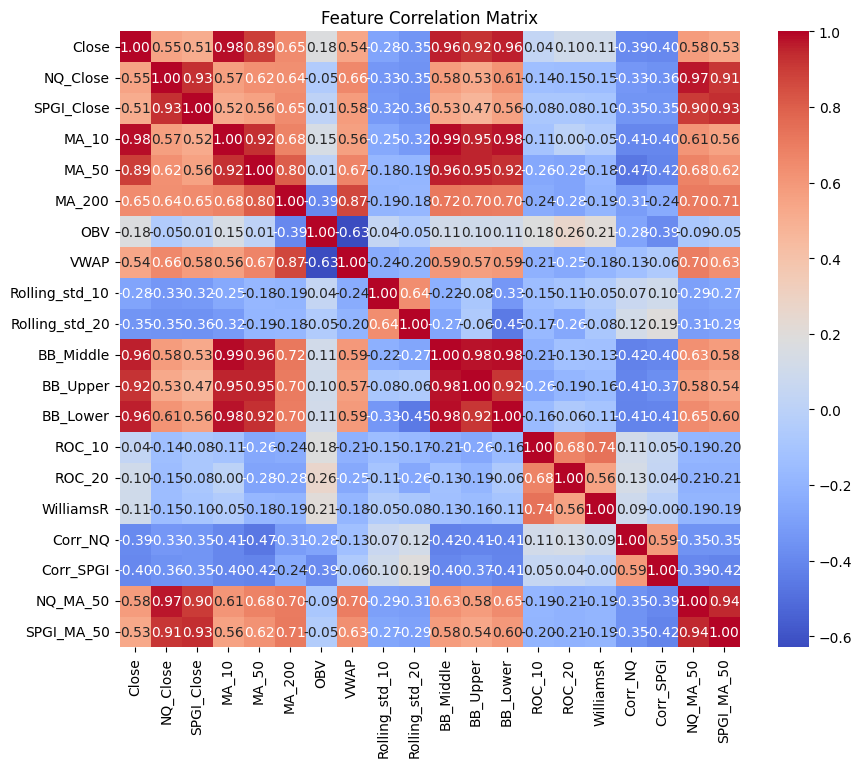

In [31]:
def show_feature_correlation(df):

  """
  Plots a correlation matrix of the features after scaling.

  Parameters:
  - df: DataFrame of features from preprocess_data()
  """

  corr_matrix = df.corr()
  plt.figure(figsize=(10,8))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  plt.title('Feature Correlation Matrix')
  plt.show()

show_feature_correlation(df)

## **Modeling**

**Recall:**

X_train.shape[0] --> N --> samples

X_train.shape[1] --> T --> time

X_train.shape[2] --> D --> features

### Model Configuration

In [41]:
def get_model_config(ticker):
  """
  Returns model hyperparameters based on whether the ticker is an index or
  individual stock.
  """

  stock_tickers = ['AAPL', 'FOX', 'JPM', 'NFLX', 'SPOT']
  index_tickers = ['DOW', '^GSPC', '^IXIC', '^RUT']

  # individual stock hyperparameter optimization
  if ticker in stock_tickers:
    config = {
        # 'dense_unit_1': 25,
        # 'dropout_1': 0.2,
        # 'dense_unit_2': 25,
        # 'dropout_2': 0.3

        'dense_unit_1': 25,
        'dropout_1': 0.2,
        'dense_unit_2': 50,
        'dropout_2': 0.3
    }
  elif ticker in index_tickers:
    config = {
        'dense_unit_1': 25,
        'dropout_1': 0.1,
        'dense_unit_2': 50,
        'dropout_2': 0.1
    }
  else:
    config = {'dropout_1': 0.2, 'dropout_2': 0.2,
              'dense_unit_1': 25, 'dense_unit_2': 50}

  print(f"Training model for {ticker} with configuration: {config}\n\n")
  return config

config = get_model_config(ticker)

Training model for DOW with configuration: {'dense_unit_1': 25, 'dropout_1': 0.1, 'dense_unit_2': 50, 'dropout_2': 0.1}




### Model Architecture

In [18]:
def train_lstm(X_train, y_train, X_test, y_test, epochs=75, batch_size=32,
                                                              config=config):

  """
  Trains and compiles a sequential model on an LSTM neural network with
  time series data.

  Parameters:
  - X_train: Training set input features
  - y_train: Training set actual values
  - X_test: Test set input features
  - y_test: Test set actual values
  - epochs: Number of full iterations
  - batch_size: Number of training samples processed in a single epoch

  Returns:
  model, history
  """

  input_shape = (X_train.shape[1], X_train.shape[2])

  model = Sequential([
        Input(shape=input_shape),
        LSTM(100, return_sequences=True),
        Dense(config['dense_unit_1']),
        Dropout(config['dropout_1']),
        LSTM(50),
        Dense(config['dense_unit_2']),
        Dropout(config['dropout_2']),
        Dense(1)
    ])

  model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                                    epochs=epochs, batch_size=batch_size,
                                                              verbose=2)

  return model, history

### Train and Compile

In [19]:
lstm_model, history = train_lstm(X_train, y_train, X_test, y_test)
lstm_predictions = lstm_model.predict(X_test)

Epoch 1/75
29/29 - 13s - 463ms/step - loss: 0.2589 - val_loss: 0.0125
Epoch 2/75
29/29 - 1s - 21ms/step - loss: 0.0179 - val_loss: 0.0082
Epoch 3/75
29/29 - 1s - 23ms/step - loss: 0.0125 - val_loss: 0.0090
Epoch 4/75
29/29 - 1s - 30ms/step - loss: 0.0108 - val_loss: 0.0077
Epoch 5/75
29/29 - 1s - 28ms/step - loss: 0.0091 - val_loss: 0.0069
Epoch 6/75
29/29 - 1s - 48ms/step - loss: 0.0086 - val_loss: 0.0065
Epoch 7/75
29/29 - 1s - 28ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 8/75
29/29 - 0s - 12ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 9/75
29/29 - 1s - 17ms/step - loss: 0.0076 - val_loss: 0.0043
Epoch 10/75
29/29 - 1s - 21ms/step - loss: 0.0070 - val_loss: 0.0042
Epoch 11/75
29/29 - 1s - 25ms/step - loss: 0.0061 - val_loss: 0.0038
Epoch 12/75
29/29 - 1s - 18ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 13/75
29/29 - 0s - 17ms/step - loss: 0.0053 - val_loss: 0.0030
Epoch 14/75
29/29 - 1s - 21ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 15/75
29/29 - 1s - 21ms/step - loss

### Model Summary

In [20]:
def print_model_summary(model):
  model.summary()

summary = print_model_summary(lstm_model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          48,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 60, 25)              │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 25)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          15,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,180 (805.39 KB)

 Trainable params: 68,726 (268.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,454 (536.93 KB)

## **Validation**

### Calculate Loss (MSE, RMSE, MAE)

In [21]:
def calculate_loss(y_test, lstm_predictions):

  mse = mean_squared_error(y_test, lstm_predictions)
  rmse = root_mean_squared_error(y_test, lstm_predictions)
  mae = mean_absolute_error(y_test, lstm_predictions)

  print(f'\nMSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}\n')

calculate_loss(y_test, lstm_predictions)


MSE: 0.0008723071801700544
RMSE: 0.029534846879069043
MAE: 0.024031318236191337



### Plot Validation Loss (MSE)

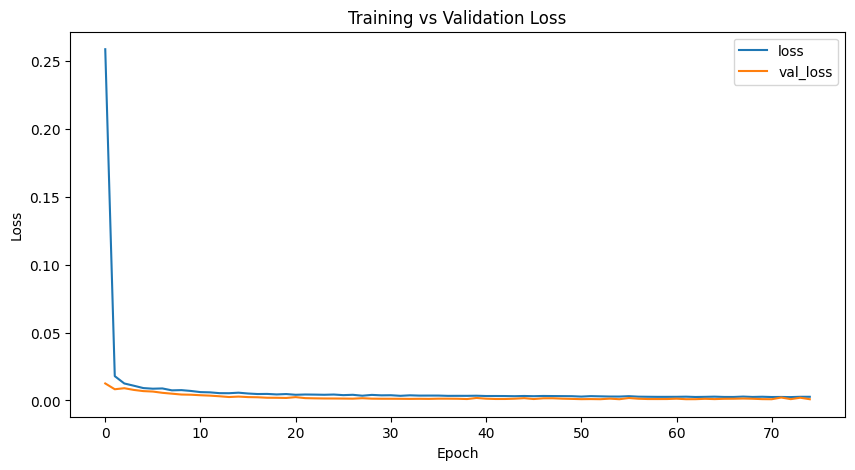

In [22]:
def plot_training_history(history):

  """
  Plots the training and validation loss for each epoch.

  Parameters:
  - history: fitted model
  """

  plt.figure(figsize=(10,5))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Validation Loss')
  plt.legend()
  plt.show()

plot_training_history(history)

## **Evaluation**

### Feature Importance -- Permutation Method

In [23]:
def permutation_feature_importance(model, X_test, y_test, features=FEATURES):

  """
  Evaluates feature importance by measuring the increase in MSE after shuffling
  each feature in X_test.

  Parameters:
  - model: Trained LSTM model
  - X_test: Test set input features
  - y_test: Test set actual values
  - features: Global feature set

  Returns:
  df of features sorted by importance
  """

  baseline_pred = model.predict(X_test, verbose=0)
  baseline_mse = mean_squared_error(y_test, baseline_pred)

  importances = {}

  for i, feature in enumerate(features):
    X_permuted = np.copy(X_test)

    # shuffle values for this feature across all samples and timesteps
    for t in range(X_permuted.shape[1]):
      np.random.shuffle(X_permuted[:, t, i])

    permuted_pred = model.predict(X_permuted, verbose=0)
    permuted_mse = mean_squared_error(y_test, permuted_pred)

    # importance is the increase in error caused by shuffling this feature
    importances[feature] = permuted_mse - baseline_mse

  # sort and display results
  importance_df = pd.DataFrame(importances.items(), columns=['Feature', 'Importance']
                               ).sort_values(by='Importance', ascending=False)

  # print("\nFeature Importance (Permutation Method):")
  # print(importance_df)

  return importance_df

importance_df = permutation_feature_importance(lstm_model, X_test, y_test, FEATURES)
print(importance_df)

           Feature  Importance
15       WilliamsR    0.002078
0            Close    0.000998
12        BB_Lower    0.000394
3            MA_10    0.000387
14          ROC_20    0.000324
4            MA_50    0.000174
10       BB_Middle    0.000170
2       SPGI_Close    0.000128
11        BB_Upper    0.000092
7             VWAP    0.000052
17       Corr_SPGI    0.000037
19      SPGI_MA_50    0.000024
9   Rolling_std_20    0.000023
5           MA_200    0.000020
8   Rolling_std_10    0.000004
13          ROC_10    0.000003
18        NQ_MA_50   -0.000067
1         NQ_Close   -0.000109
6              OBV   -0.000126
16         Corr_NQ   -0.000269


### Plot Top Feature Importances

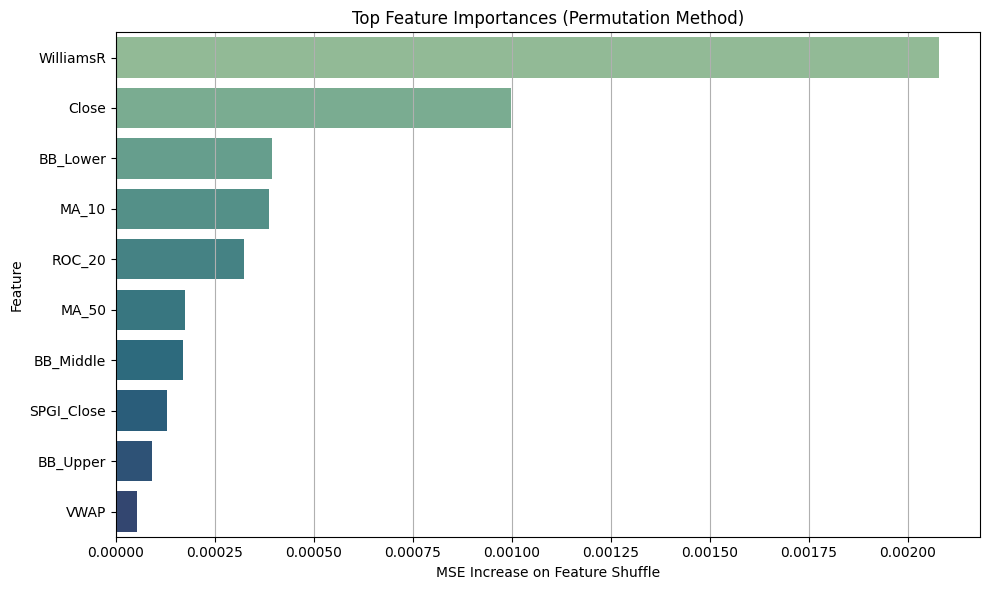

In [24]:
def plot_feature_importance(importance_df, top_n=10):

  plt.figure(figsize=(10,6))
  sns.barplot(data=importance_df.head(top_n), x='Importance', y='Feature', hue='Feature',
              palette='crest', legend=False)
  plt.title('Top Feature Importances (Permutation Method)')
  plt.xlabel('MSE Increase on Feature Shuffle')
  plt.ylabel('Feature')
  plt.grid(True, axis='x')
  plt.tight_layout()
  plt.show();

plot_feature_importance(importance_df)

### Inverse Transform Predictions

In [25]:
def inverse_transform(y_test, predictions, scaler, features=FEATURES):

  """
  Inverses the scaling of predictions back to original prices.

  Parameters:
  - y_test: Ground truth values (scaled)
  - predictions: Predicted values from model (scaled)
  - scaler: the fitted MinMaxScaler used on the feature set
  - features: list of features used during scaling

  Returns:
  true_close, adj_close
  """

  # modify scaler.inverse_transform() to include features
  y_test_rescaled = np.zeros((y_test.shape[0], len(features)))
  y_test_rescaled[:,0] = y_test

  # modify scaler.inverse_transform() to include features
  preds_rescaled = np.zeros((predictions.shape[0], len(features)))
  preds_rescaled[:,0] = predictions[:,0]

  # extract the first column (closing price)
  adj_close = scaler.inverse_transform(preds_rescaled)[:,0]
  true_close = scaler.inverse_transform(y_test_rescaled)[:,0]

  return true_close, adj_close

true_prices, predicted_prices = inverse_transform(y_test, lstm_predictions, scaler)

### Calculate Error

In [26]:
def compute_error(true, adj):
  pct_error = np.mean(np.abs(true-adj) / true) * 100
  print(f'\nAverage Percentage Error: {pct_error:.2f}%\n')

  return pct_error

error = compute_error(true_prices, predicted_prices)


Average Percentage Error: 2.13%



### Plot True vs Predicted Prices

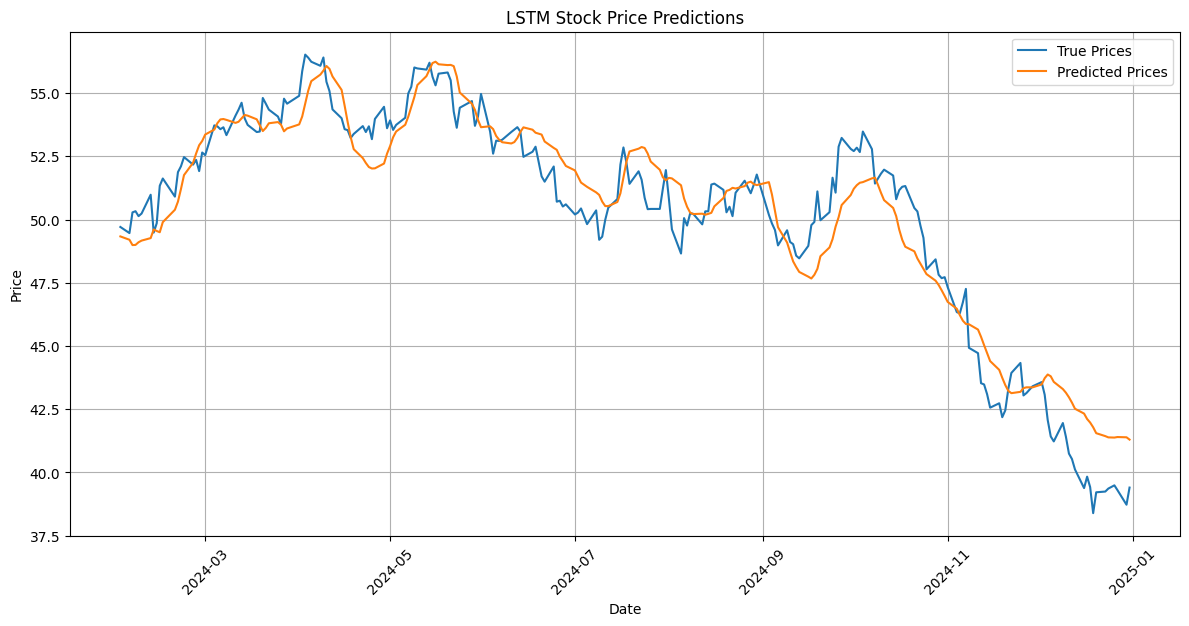

In [27]:
def plot_predictions_with_dates(df, true_prices, predicted_prices, lookback,
                                                              split_ratio):

  """
  Plots actual vs. predicted stock prices over time with proper date labels.

  Parameters:
  - df: Original DataFrame with full date index
  - true_prices: Actual prices after inverse transform
  - predicted_prices: Model predictions after inverse transform
  - lookback: number of days in input window
  - split_ratio: train/test split ratio
  """

  # align with end of test set
  total_samples = lookback + len(true_prices)
  dates = df.index[-len(true_prices):]

  plt.figure(figsize=(12,6))
  plt.plot(dates, true_prices, label='True Prices')
  plt.plot(dates, predicted_prices, label='Predicted Prices')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('LSTM Stock Price Predictions')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.xticks(rotation=45)
  plt.show()

plot_predictions_with_dates(df, true_prices, predicted_prices, lookback, split_ratio)

### DataFrame of Closing Prices

In [28]:
def compare_prices(df, y_test, true_prices, predicted_prices):

  df_close = pd.DataFrame({
      'Date': df.index[-len(y_test):],
      'True Close': true_prices,
      'Adjusted Close': predicted_prices,
  })

  print('\nDataFrame of True vs Predicted Prices\n')
  print(df_close)

compare_prices(df, y_test, true_prices, predicted_prices)


DataFrame of True vs Predicted Prices

          Date  True Close  Adjusted Close
0   2024-02-02   49.705959       49.331885
1   2024-02-05   49.464043       49.200602
2   2024-02-06   50.282856       48.989813
3   2024-02-07   50.329384       48.996203
4   2024-02-08   50.133980       49.101889
..         ...         ...             ...
225 2024-12-24   39.359764       41.384683
226 2024-12-26   39.487396       41.376930
227 2024-12-27   39.300854       41.397969
228 2024-12-30   38.721600       41.387593
229 2024-12-31   39.399036       41.297104

[230 rows x 3 columns]


## **Pipeline Script**

In [29]:
def run_prediction_pipeline(ticker):
    """
    Loads and preprocesses data, trains the model, and generates predictions.
    Saves results to the global `state` dictionary and key variables to the global namespace.
    Returns the full `state` for optional inspection.
    """

    global df, history, X_test, y_test, true_prices, predicted_prices, model, error

    print(f"\nRunning LSTM prediction for {ticker}...\n")

    # Load and preprocess
    df = prepare_data(ticker)
    X_train, X_test, y_train, y_test, scaler, df = preprocess_data(df, lookback, split_ratio)

    # Train model
    model_config = get_model_config(ticker)
    model, history = train_lstm(X_train, y_train, X_test, y_test, config=model_config)

    # Predict
    predictions = model.predict(X_test)

    # Validate
    loss = calculate_loss(y_test, predictions)

    # Evaluate
    true_prices, predicted_prices = inverse_transform(y_test, predictions, scaler)
    error = compute_error(true_prices, predicted_prices)

    return df, history, X_test, y_test, true_prices, predicted_prices, error

## **User Interface**

In [38]:
state = {
    'df': None,
    'X_test': None,
    'y_test': None,
    'true_prices': None,
    'predicted_prices': None,
    'model': None,
    'history': None,
    'error': None,
    'feature_list': None
}

import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import VBox, HBox, Tab
import io
from contextlib import redirect_stdout

# --- Global State ---
pipeline_output = widgets.Output()
viz_output = widgets.Output()
# df = model = history = true_prices = predicted_prices = y_test = X_test = None

# --- Widgets ---
ticker_dropdown = widgets.Dropdown(
    options=['AAPL', 'AXP', 'DOW', 'FOX', 'GOOGL', '^GSPC', '^IXIC', 'JPM', 'LMT', 'MA', 'MSFT',
             'NFLX', '^RUT', 'SPOT'],
    value='DOW',
    description='Ticker:',
    layout=widgets.Layout(width='200px')
)

run_button = widgets.Button(
    description='Run Pipeline',
    button_style='success',
    layout=widgets.Layout(width='150px')
)

viz_dropdown = widgets.Dropdown(
    options=[
        'Feature Correlation Matrix',
        'Model Summary',
        'Training vs Validation Loss',
        'Feature Importance',
        'True vs Predicted Prices',
        'Price Comparison Table'
    ],
    description='Visual:',
    layout=widgets.Layout(width='350px')
)

show_button = widgets.Button(
    description='Show',
    button_style='info',
    layout=widgets.Layout(width='100px')
)

reset_button = widgets.Button(
    description='Reset All',
    button_style='danger',
    layout=widgets.Layout(width='120px')
)

# --- Utility: Get Model Summary as Text (avoid infinite loop) ---
def get_model_summary_text(model):
    buf = io.StringIO()
    with redirect_stdout(buf):
        model.summary()
    return buf.getvalue()

# --- Callbacks ---
def on_run_click(b):
    with pipeline_output:
        clear_output(wait=True)
        ticker = ticker_dropdown.value

        df, history, X_test, y_test, true_prices, predicted_prices, error = run_prediction_pipeline(ticker)

        state.update({
            'df': df,
            'history': history,
            'y_test': y_test,
            'true_prices': true_prices,
            'predicted_prices': predicted_prices,
            'error': error,
            'model': model,
            'X_test': X_test,
            'feature_list': FEATURES
        })

        print(f"Model trained for {ticker} with {len(df)} data points.")


def on_show_click(b):

    with viz_output:
        clear_output(wait=True)
        if state['model'] is None:
            print("⚠️ Please run the pipeline first.")
            return

        choice = viz_dropdown.value
        if choice == 'Model Summary':
            print(get_model_summary_text(state['model']))
        elif choice == 'True vs Predicted Prices':
            plot_predictions_with_dates(state['df'], state['true_prices'], state['predicted_prices'], lookback, split_ratio)
        elif choice == 'Feature Importance':
            importance_df = permutation_feature_importance(state['model'], state['X_test'], state['y_test'], state['feature_list'])
            plot_feature_importance(importance_df)
        elif choice == 'Training vs Validation Loss':
            plot_training_history(state['history'])
        elif choice == 'Feature Correlation Matrix':
            show_feature_correlation(state['df'])
        elif choice == 'Price Comparison Table':
            compare_prices(state['df'], state['y_test'], state['true_prices'], state['predicted_prices'])
        else:
            print("Select a visualization.")


def on_reset_click(b):
    for key in state:
        state[key] = None
    with pipeline_output:
        clear_output()
        print("Pipeline output cleared.")
    with viz_output:
        clear_output()
        print("Visualization output cleared.")

# --- Connect Buttons ---
run_button.on_click(on_run_click)
show_button.on_click(on_show_click)
reset_button.on_click(on_reset_click)

# --- Layout ---
pipeline_tab = VBox([
    HBox([ticker_dropdown, run_button, reset_button]),
    pipeline_output
])

visual_tab = VBox([
    HBox([viz_dropdown, show_button]),
    viz_output
])

tabs = Tab(children=[pipeline_tab, visual_tab])
tabs.set_title(0, 'Pipeline')
tabs.set_title(1, 'Visualization')

# --- Display UI ---
display(tabs)
